In [17]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

# Pkg.pkg"add Trapz"
Pkg.add("Trapz")

using CoordinateTransformations
using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using Printf
using LinearAlgebra
using Plots
using Trapz

include(joinpath(@__DIR__, "zoe2.jl"))
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "planner.jl"))


  Activating project at `~/Downloads/MSR Academics/zoe2_optimal_controller/julia`
   Resolving package versions...
  No Changes to `~/Downloads/MSR Academics/zoe2_optimal_controller/julia/Project.toml`
  No Changes to `~/Downloads/MSR Academics/zoe2_optimal_controller/julia/Manifest.toml`


main (generic function with 1 method)

Segment length: 6.801948114390082
Num pts in Segment: 27
Segment length: 12.899964517693888
Num pts in Segment: 52
Segment length: 6.810026807779111
Num pts in Segment: 27


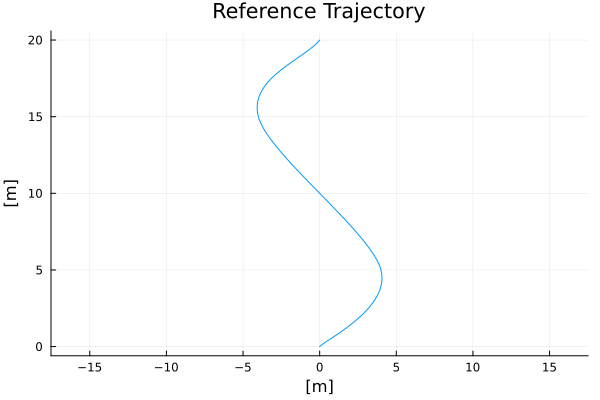

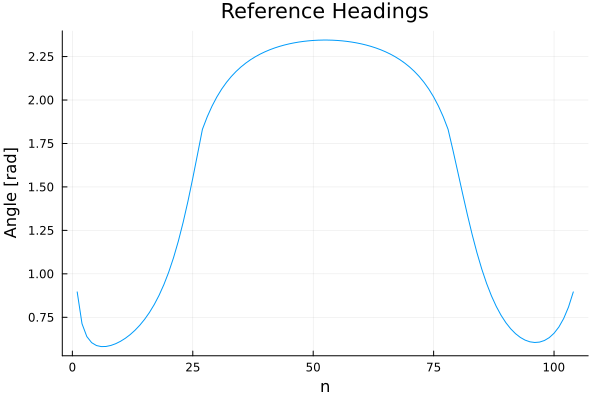

In [18]:

points = [
    [0.0, 0.0],
    [4.0, 5.0],
    [-4.0, 15.0],
    [0.0, 20.0]
]

params = (v_b=25,
        dt=.01,
        r=0.325,
        L=1.91,
        B=1.64)

Xref, Uref = generate_trajectory(points, params) 
# println(Xref)
# println(Uref)

x_pos = [Xref[i][1] for i in 1:length(Xref)]
y_pos = [Xref[i][2] for i in 1:length(Xref)]
headings = [Xref[i][3] for i in 1:length(Xref)]

display(plot(x_pos,y_pos,label="",xlabel = "[m]", ylabel = "[m]",title = "Reference Trajectory"; aspect_ratio=:equal))
display(plot(headings,label="",xlabel = "n", ylabel = "Angle [rad]",title = "Reference Headings"))

In [19]:
function dynamics(params::NamedTuple, x::Vector, u::Vector)
    # ODE, parametrized by params

    # physical parameters 
    r, L, B = params.r, params.L, params.B
    ωfl, ωfr, ωrl, ωrr = u
    xb, yb, ψb, θf, θr = x
    
    vf = r/2*(ωfl + ωfr)
    vr = r/2*(ωrl + ωrr)
    vb = 0.5*(vf/cos(θr) + vr/cos(θf)) * sqrt(cos(θr)*cos(θf)*cos(θf+θr) + 0.25*(sin(θf+θr))^2)

    xdot = [vb*cos(ψb);
            vb*sin(ψb);
            sin(θf+θr)/(2*L)*(vf/cos(θr) + vr/cos(θf));
            r/B*(ωfr - ωfl);
            r/B*(ωrl - ωrr)]

    return xdot
end

function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    #hermite simpson implicit integrator residual 

    xm = 0.5*(x1 + x2) + (dt/8)*(dynamics(params,x1,u) - dynamics(params,x2,u))
    residual = x1 + (dt/6)*(dynamics(params,x1,u) + 4*dynamics(params,xm,u) +
        dynamics(params,x2,u)) - x2
    
    return residual

end

hermite_simpson (generic function with 1 method)

In [20]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

# return a scalar 
function cost(params::NamedTuple, Z::Vector)::Real
    idx, N = params.idx, params.N
    Q, R, Qf = params.Q, params.R, params.Qf
    Xref, xg = params.Xref, params.xg

    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        # J += 0.5*(xi-xg)'*Q*(xi-xg) + 0.5*ui'*R*ui
        J += 0.5*(xi-Xref[i])'*Q*(xi-Xref[i]) + 0.5*ui'*R*ui
    end
    
    #terminal cost 
    xN = Z[idx.x[N]]
    J += 0.5*(xN-Xref[N])'*Qf*(xN-Xref[N])

    return J
end

function dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    #create dynamics constraints using hermite simpson 
    
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # hermite simpson 
        # c[idx.c[i]] = zeros(4)
        #x1 is x_k,  x2 is x_k+1 
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
    end

    return c 
end

function equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    #return all of the equality constraints (dynamics, IC, and goal)  IC and goal constraints only enforced for x and y body position
    return [dynamics_constraints(params,Z); Z[idx.x[1]][1:2] - xic; Z[idx.x[N]][1:2] - xg]

end


function solve_trajOpt(Xref, Uref, input_params, ;verbose=true)
    
    # Xref, Uref = generate_trajectory(points, ref_traj_params) 
    v_b = input_params.v_b
    dt = input_params.dt
    r = input_params.r
    L = input_params.L
    B = input_params.B

    # problem size 
    nx = 5
    nu = 4 
    N = length(Xref)


    tf = (N-1)*dt
    t_vec = 0:dt:tf  #check dims match up

    # LQR cost 
    Q = diagm([1;1;.5;.1;.1])
    R = 0.1*diagm(ones(nu))
    Qf = 40*diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states.  Only enforce for x and y body position
    xic = Xref[1][1:2]
    xg = Xref[N][1:2]
    
    # load all useful things into params 
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, 
            N = N, idx = idx, r = r, L = L, B = B, Xref = Xref)
    
    # primal bounds 
    # x_l = 
    # x_u =  
    ####
    x_l = -Inf* ones(idx.nz)
    x_u = Inf* ones(idx.nz)

    # uidx = [collect(r)[1] for r in idx.u] #makes array of all u indices

    #can set wheel velocity constraints here
    # x_l[uidx] .= -100
    # x_u[uidx] .= 100

    for i in 1:(N-1)
        x_l[idx.u[i]] .= -4
        x_u[idx.u[i]] .= 4

        x_l[idx.x[i][4:5]] .= -25 *pi/180
        x_u[idx.x[i][4:5]] .= 25 *pi/180
    end
    x_l[idx.x[N][4:5]] .= -25 *pi/180
    x_u[idx.x[N][4:5]] .= 25 *pi/180

    # display(uidx)
    # display(x_l)

    
    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess 
    z0 = 0.001*randn(idx.nz)

    for i in 1:(N-1)
        z0[idx.x[i]] = Xref[i]
        z0[idx.u[i]] = Uref[i]
    end
    z0[idx.x[N]] = Xref[N]

    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    diff_type = :auto 
    # diff_type = :finite
    
    # println(z0[idx.x[1]][1:2])
    
    Z = fmincon(cost, equality_constraint, inequality_constraint,
                x_l, x_u, c_l, c_u, z0, params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, t_vec, params 
end



solve_trajOpt (generic function with 1 method)

In [ ]:
#waypoints.  Should be able to add whatever to create the desired path
points = [
    [0.0, 0.0],
    [4.0, 5.0],
    [-4.0, 15.0],
    [0.0, 20.0]
]

v_b = 1
dt = .1
r = 0.325
L = 1.91
B = 1.64

input_params = (v_b = v_b, dt = dt, r = r, L=L, B=B)

Xref, Uref = generate_trajectory(points, input_params) 

X, U, t_vec = solve_trajOpt(Xref, Uref, input_params, verbose = true)
Xm = hcat(X...)
Um = hcat(U...)

Xrefm = hcat(Xref...)
Urefm = hcat(Uref...)

plot(t_vec,Xrefm', ls = :dash, label=["xr" "yr" "ψr" "θfr" "θrr" ])
display(plot!(t_vec, Xm', label = ["x" "y" "ψ" "θf" "θr" ], xlabel = "time (s)", 
        title = "State Trajectory"))
display(plot(t_vec[1:end-1],Um',label = ["ωfl" "ωfr" "ωrl" "ωrr"], xlabel = "time (s)", ylabel = "u",title = "Controls"))


Segment length: 6.801948114390082
Num pts in Segment: 68
Segment length: 12.899964517693888
Num pts in Segment: 129
Segment length: 6.810026807779111
Num pts in Segment: 68
---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----


In [ ]:

vis = Visualizer()
# open(vis)  # open the visualizer in a separate tab/window
render(vis) # render the visualizer here inside the jupyter notebook

urdf_path = joinpath(@__DIR__, "zoe2.urdf")
robot = parse_urdf(urdf_path)
mvis = MechanismVisualizer(robot, URDFVisuals(urdf_path), vis)

# Create a state for the mechanism
state = MechanismState(robot)
q = configuration(state)

println("Initial configuration vector:")
println(q)
println("Number of degrees of freedom: ", length(q))

# Iterate over the joints to print their names
for (i, joint) in enumerate(joints(robot))
    println("Joint ", i, ": ", joint.name)
end

# Example: update a joint value
# q[2] = 0.3
# q[3] = -0.3

# Update the visualizer with the new configuration
set_configuration!(mvis, q)

# state = MechanismState(robot, randn(2), randn(2))
# t, q, v = simulate(state, 5.0);

animate_zoe2(X, input_params.dt)